<a href="https://colab.research.google.com/github/MinhVuong2000/Data-Science/blob/master/%08Airline_Arrival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
Use this [dataset of airline arrival information](http://stat-computing.org/dataexpo/2009/the-data.html) to predict how late flights
will be. A flight only counts as late if it is more than 30 minutes late.
1. Examine and explore data
2. Apply models in Naïve Bayes, Logistic Regression, Decision
Tree, Random Forest, Gradient Boosting and SVM.
3. Apply PCA, SelectKBest and RFE for feature selections.
4. Using gridsearchCV to obtain best parameters for models.
5. Compare performances among models, write up analysis
why the model is good or bad in the algorithmic approach
(explain why the algorithm is good or bad for the dataset
structure, can you do something to improve the model?)
6. The conclusions.

##Get data from uploading Kaggle

In [ ]:
!import file from kaggle
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d minhvuong2000/airlinearrival
!ls

/bin/bash: import: command not found


Saving kaggle.json to kaggle.json
 97% 209M/214M [00:01<00:00, 114MB/s]
100% 214M/214M [00:01<00:00, 159MB/s]
airlinearrival.zip  kaggle.json  sample_data


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('airlinearrival.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
!ls files

624575656_T_ONTIME_REPORTING_M1.csv  624645950_T_ONTIME_REPORTING_M4.csv
624575656_T_ONTIME_REPORTING_M6.csv  624645950_T_ONTIME_REPORTING_M5.csv
624645950_T_ONTIME_REPORTING_M2.csv  624645950_T_ONTIME_REPORTING_M7.csv
624645950_T_ONTIME_REPORTING_M3.csv  airline-arrival.csv


In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn import metrics

In [ ]:
"""
#merge data from 7 files respective 7 month in 2020
extension = 'csv'
all_filenames = [i for i in glob.glob('files/*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "airline-arrival.csv", index=False)"""

'\n#merge data from 7 files respective 7 month in 2020\nextension = \'csv\'\nall_filenames = [i for i in glob.glob(\'files/*.{}\'.format(extension))]\n#combine all files in the list\ncombined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])\n#export to csv\ncombined_csv.to_csv( "airline-arrival.csv", index=False)'

In [ ]:
data = pd.read_csv("files/airline-arrival.csv")
data.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2900462, 48)

#Examine and explore Data

##Examine data

In [ ]:
data.info(null_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900462 entries, 0 to 2900461
Data columns (total 48 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 2900462 non-null  int64  
 1   QUARTER              2900462 non-null  int64  
 2   MONTH                2900462 non-null  int64  
 3   DAY_OF_MONTH         2900462 non-null  int64  
 4   DAY_OF_WEEK          2900462 non-null  int64  
 5   FL_DATE              2900462 non-null  object 
 6   DEST_AIRPORT_ID      2900462 non-null  int64  
 7   DEST_AIRPORT_SEQ_ID  2900462 non-null  int64  
 8   DEST_CITY_MARKET_ID  2900462 non-null  int64  
 9   DEST                 2900462 non-null  object 
 10  DEST_CITY_NAME       2900462 non-null  object 
 11  DEST_STATE_ABR       2900462 non-null  object 
 12  DEST_STATE_FIPS      2900462 non-null  int64  
 13  DEST_STATE_NM        2900462 non-null  object 
 14  DEST_WAC             2900462 non-null  int64  
 15

From this data, have some nan data. So we will drop column which have nan data >50%, and fill 0 in rest nan data

In [ ]:
#drop all-nan column
for col in data.columns:
  i = data.columns.get_loc(col)
  if (data.iloc[:,i].isna().sum()>0.5* len(data.iloc[:,i])):
    data = data.drop([col], axis=1)
data = data.fillna(0)#replace nan to 0
data.info(null_counts=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900462 entries, 0 to 2900461
Data columns (total 41 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   YEAR                 2900462 non-null  int64  
 1   QUARTER              2900462 non-null  int64  
 2   MONTH                2900462 non-null  int64  
 3   DAY_OF_MONTH         2900462 non-null  int64  
 4   DAY_OF_WEEK          2900462 non-null  int64  
 5   FL_DATE              2900462 non-null  object 
 6   DEST_AIRPORT_ID      2900462 non-null  int64  
 7   DEST_AIRPORT_SEQ_ID  2900462 non-null  int64  
 8   DEST_CITY_MARKET_ID  2900462 non-null  int64  
 9   DEST                 2900462 non-null  object 
 10  DEST_CITY_NAME       2900462 non-null  object 
 11  DEST_STATE_ABR       2900462 non-null  object 
 12  DEST_STATE_FIPS      2900462 non-null  int64  
 13  DEST_STATE_NM        2900462 non-null  object 
 14  DEST_WAC             2900462 non-null  int64  
 15

After drop, we have 2900462 rows and 41 features

#Analysis

Transform features have type is object

In [ ]:
from sklearn import preprocessing
#transform object data
#new_data = data.select_dtypes(include='int64')

le = preprocessing.LabelEncoder()
cat_features=[x for x in data.columns if data[x].dtype=="object"]
for col in cat_features:
      i = data.columns.get_loc(col)
      data.iloc[:,i] = le.fit_transform(data.iloc[:,i])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900462 entries, 0 to 2900461
Data columns (total 41 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   QUARTER              int64  
 2   MONTH                int64  
 3   DAY_OF_MONTH         int64  
 4   DAY_OF_WEEK          int64  
 5   FL_DATE              int64  
 6   DEST_AIRPORT_ID      int64  
 7   DEST_AIRPORT_SEQ_ID  int64  
 8   DEST_CITY_MARKET_ID  int64  
 9   DEST                 int64  
 10  DEST_CITY_NAME       int64  
 11  DEST_STATE_ABR       int64  
 12  DEST_STATE_FIPS      int64  
 13  DEST_STATE_NM        int64  
 14  DEST_WAC             int64  
 15  CRS_DEP_TIME         int64  
 16  DEP_TIME             float64
 17  DEP_DELAY            float64
 18  DEP_DELAY_NEW        float64
 19  DEP_DEL15            float64
 20  DEP_DELAY_GROUP      float64
 21  DEP_TIME_BLK         int64  
 22  TAXI_OUT             float64
 23  WHEELS_OFF           float64
 24

In [ ]:
#function to return to if a flight is late
def isLate(DepDelay, ArrDelay):
  if (DepDelay>30 or ArrDelay>30): return 1
  return 0
#create column to describle late or no - that is label
LATE_FLIGHT = [isLate(data.DEP_DELAY_NEW[i],data.ARR_DELAY_NEW[i]) for i in range (data.shape[0])]

data['LATE_FLIGHT'] = LATE_FLIGHT
data['LATE_FLIGHT'].value_counts(normalize=True)

0    0.931618
1    0.068382
Name: LATE_FLIGHT, dtype: float64

LATE_FLIGHT is the label
We can see that, there is high diferrence between label 0 and 1. <br>So, we need make balance data by combine both oversampling and undersampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

over = RandomOverSampler(sampling_strategy=1)
#under = RandomUnderSampler(sampling_strategy=1)

columns = data.columns

data,LATE_FLIGHT = over.fit_resample(data,LATE_FLIGHT)
#X,y = under.fit_resample(X,y)

#change type data beacause data now is numpy.ndarray
data = pd.DataFrame(data, columns=columns)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from collections import Counter
print(sorted(Counter(data['LATE_FLIGHT']).items()))

[(0.0, 2702124), (1.0, 2702124)]


#### Now, We find feature that is high correlation with label, to drop them

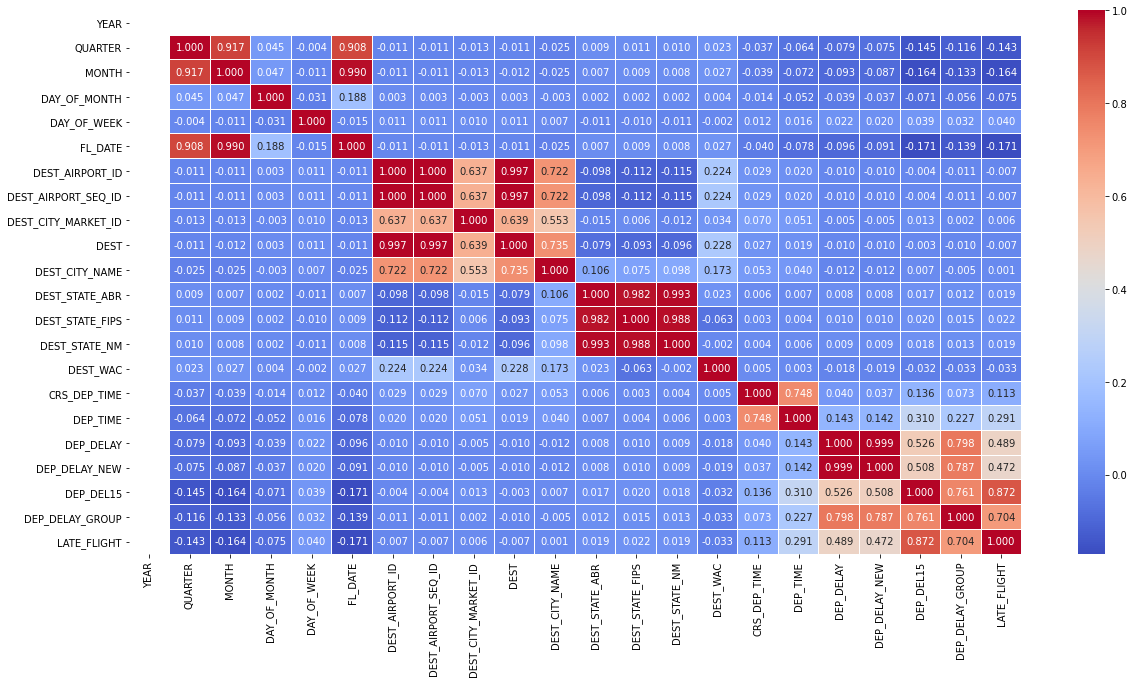

In [ ]:
#correlation to know label has high correlation with what features
import seaborn as sns
import matplotlib.pyplot as plt

mid = int(data.shape[1]/2)
list = data.columns[:mid].append(data.columns[-1:])
fig, ax = plt.subplots(figsize=(20,10))    
g = sns.heatmap(data[list].corr(),annot=True, fmt = ".3f", cmap = "coolwarm",linewidths= 0.01,ax=ax)

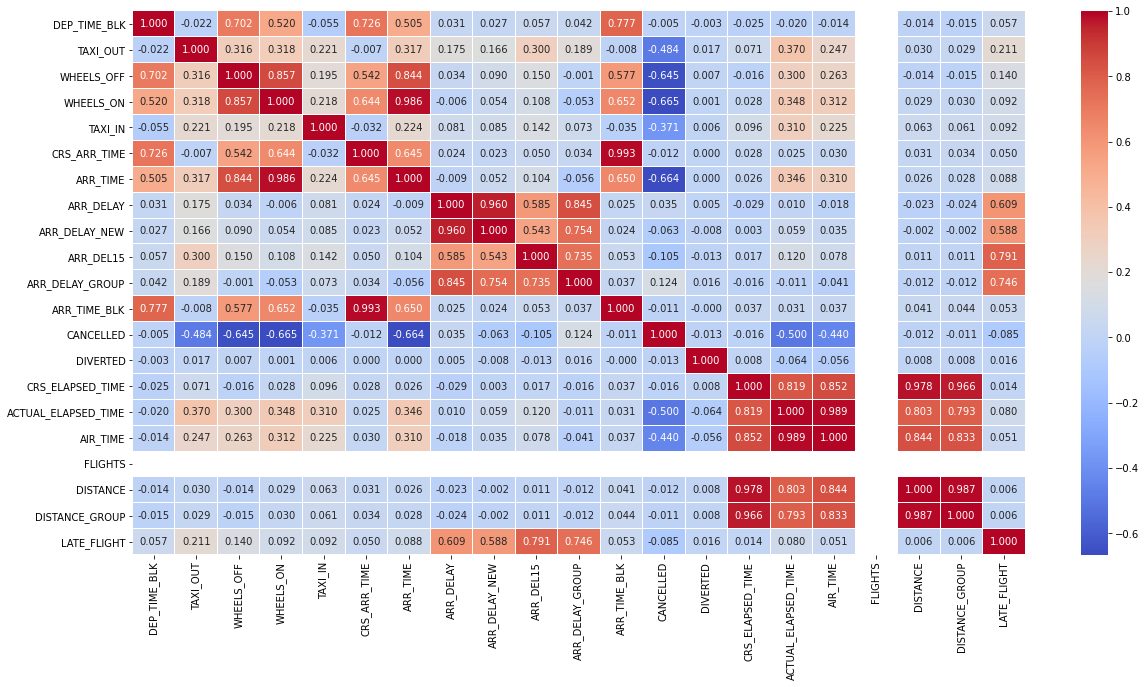

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))   
h = sns.heatmap(data[data.columns[mid:]].corr(),annot=True, fmt = ".3f", cmap = "coolwarm",linewidths= 0.01,ax=ax)

So, we drop features: DEP_DELAY, DEP_DELAY_NEW, DEP_DEL15, DEP_DELAY_GROUP, FLIGHTS,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15, ARR_DELAY_GROUP


In [ ]:
data = data.drop(columns=['DEP_DELAY', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_DELAY_GROUP', 'FLIGHTS', 
                          'ARR_DELAY', 'ARR_DELAY_NEW', 'ARR_DEL15', 'ARR_DELAY_GROUP','LATE_FLIGHT'])
data.shape

(5404248, 32)

## **Apply models**

In [ ]:
"""
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))
"""

#### Create feature and label

In [ ]:
X = data #Features
y = LATE_FLIGHT #label

from sklearn.model_selection import train_test_split # Import train_test_split function

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

#### [Naïve Bayes](https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn)
1. **Advantage**
- Naive Bayes has very low computation cost.
- It can efficiently work on a large dataset.
- It performs well in case of discrete response variable compared to the continuous variable.
- It can be used with multiple class prediction problems.
- It also performs well in the case of text analytics problems.
- When the assumption of independence holds, a Naive Bayes classifier performs better compared to other models like logistic regression.
2. **Disadvantages**
- The assumption of independent features. In practice, it is almost impossible that model will get a set of predictors which are entirely independent.
- If there is no training tuple of a particular class, this causes zero posterior probability. In this case, the model is unable to make predictions. This problem is known as Zero Probability/Frequency Problem.

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets
%time gnb.fit(X_train,y_train)

y_pred = gnb.predict(X_test)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))
#auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc: ",metrics.auc(fpr, tpr))

CPU times: user 1.89 s, sys: 34.9 ms, total: 1.92 s
Wall time: 1.93 s
f1-score:  0.6257232820574502
auc:  0.6238139473915516


#### [Logistic Regression](https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)
1. **Advantage**
- Because of its efficient and straightforward nature, doesn't require high computation power, easy to implement, easily interpretable, used widely by data analyst and scientist. Also, it doesn't require scaling of features. Logistic regression provides a probability score for observations.
2. **Disadvantages**
- Logistic regression is not able to handle a large number of categorical features/variables. It is vulnerable to overfitting. Also, can't solve the non-linear problem with the logistic regression that is why it requires a transformation of non-linear features. Logistic regression will not perform well with independent variables that are not correlated to the target variable and are very similar or correlated to each other.

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
%time logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))
#auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc: ",metrics.auc(fpr, tpr))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CPU times: user 1min 25s, sys: 13.5 s, total: 1min 39s
Wall time: 1min 1s
f1-score:  0.7788475249726285
auc:  0.774250406731314


#### [Decision Tree](https://www.datacamp.com/community/tutorials/decision-tree-classification-python)
1. **Advantage**
- Decision trees are easy to interpret and visualize.
- It can easily capture Non-linear patterns.
- It requires fewer data preprocessing from the user, for example, there is no need to normalize columns.
- It can be used for feature engineering such as predicting missing values, suitable for variable selection.
- The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm.
2. **Disadvantages**
- Sensitive to noisy data. It can overfit noisy data.
- The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
- Decision trees are biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics

# Create Decision Tree classifer object
dtc = DecisionTreeClassifier()

# Train Decision Tree Classifer
%time dtc.fit(X_train,y_train)

y_pred = dtc.predict(X_test)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))
#auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc: ",metrics.auc(fpr, tpr))

CPU times: user 3min 1s, sys: 24.6 ms, total: 3min 1s
Wall time: 3min 1s
f1-score:  0.9965490634885014
auc:  0.9965387063037108


#### [Random Forest](https://www.datacamp.com/community/tutorials/random-forests-classifier-python)
1. **Advantage**
- Random forests is considered as a highly accurate and robust method because of the number of decision trees participating in the process.
- It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
- The algorithm can be used in both classification and regression problems.
- Random forests can also handle missing values. There are two ways to handle these: using median values to replace continuous variables, and computing the proximity-weighted average of missing values.
- You can get the relative feature importance, which helps in selecting the most contributing features for the classifier.
2. **Disadvantage**
- Random forests is slow in generating predictions because it has multiple decision trees. Whenever it makes a prediction, all the trees in the forest have to make a prediction for the same given input and then perform voting on it. This whole process is time-consuming.
- The model is difficult to interpret compared to a decision tree, where you can easily make a decision by following the path in the tree.

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
%time rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_test)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))
#auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc: ",metrics.auc(fpr, tpr))

CPU times: user 39min 57s, sys: 1.06 s, total: 39min 59s
Wall time: 39min 59s
f1-score:  0.998065301910191
auc:  0.9980624622962949


Random Forest Model make many time, more than 3 models above, but have accuracy is excellent

#### [Gradient Boosting](https://stackabuse.com/gradient-boosting-classifiers-in-python-with-scikit-learn/)
1. **Advantage**
- Often provides predictive accuracy that cannot be trumped.
- Lots of flexibility - can optimize on different loss functions and provides several hyper parameter tuning options that make the function fit very flexible.
- No data pre-processing required - often works great with categorical and numerical values as is.
- Handles missing data - imputation not required.
2. **Disadvantage**
- Gradient Boosting Models will continue improving to minimize all errors. This can overemphasize outliers and cause overfitting.
- Computationally expensive - often require many trees (>1000) which can be time and memory exhaustive.
- The high flexibility results in many parameters that interact and influence heavily the behavior of the approach (number of iterations, tree depth, regularization parameters, etc.). This requires a large grid search during tuning.
- Less interpretative in nature, although this is easily addressed with various tools.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(n_estimators=80, learning_rate=0.08, max_features=3, max_depth=8, random_state=0)
%time gbc.fit(X_train, y_train)

predictions = gbc.predict(X_test)

y_pred = gbc.predict(X_test)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))
#auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc: ",metrics.auc(fpr, tpr))

CPU times: user 13min 17s, sys: 2.37 s, total: 13min 19s
Wall time: 13min 19s
f1-score:  0.9509227890229007
auc:  0.951373235501309


##### Bonus - XGB


In [ ]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier()
%time xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))
#auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc: ",metrics.auc(fpr, tpr))

CPU times: user 10min 42s, sys: 1.08 s, total: 10min 43s
Wall time: 10min 44s
f1-score:  0.9165826216817609
auc:  0.9191325626576677


#### [SVM](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python)
1. **Advantage**
- SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm. They also use less memory because they use a subset of training points in the decision phase. SVM works well with a clear margin of separation and with high dimensional space.
2. **Disadvantage**
- SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. It works poorly with overlapping classes and is also sensitive to the type of kernel used

In [ ]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
modelSVM = svm.SVC(kernel='sigmoid')

#Train the model using the training sets
%time modelSVM.fit(X_train, y_train)

y_pred = modelSVM.predict(X_test)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))
#auc
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
print("auc: ",metrics.auc(fpr, tpr))

## **Feature Selections**

#### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X_train)
X_trainPCA = pca.transform(X_train)
X_testPCA = pca.transform(X_test)

gnb.fit(X_trainPCA,y_train)
y_pred = gnb.predict(X_testPCA)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))

f1-score:  0.6418702408059663


We can see that, performance have improve, from 62% become achive 64%

#### SelectKBest

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_selector = SelectKBest(chi2, k=5)

#drop column have negative to fit chi2
X_trainChi2 = X_train
X_testChi2 = X_test
for col in X_train.columns:
  if X_train.loc[:,col].lt(0).any():
    X_trainChi2 = X_trainChi2.drop(col,axis=1)
for col in X_test.columns:
  if X_test.loc[:,col].lt(0).any():
    X_testChi2 = X_testChi2.drop(col,axis=1)

#fit and transform
X_ktrainbest = chi2_selector.fit_transform(X_trainChi2, y_train)
X_ktestbest = chi2_selector.transform(X_testChi2)

print('Selected features:', X_trainChi2.columns[chi2_selector.get_support()])

gnb.fit(X_ktrainbest,y_train)
y_pred = gnb.predict(X_ktestbest)
#evaluation
print("f1-score: ",f1_score(y_test, y_pred))

Selected features: Index(['CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'WHEELS_ON', 'ARR_TIME'], dtype='object')
f1-score:  0.6062231445270421


We selected 5 feature best, but f1-score lower, whyy??

#### RFE

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=dtc, n_features_to_select=3)
rfe = rfe.fit(X_train, y_train)

print("Num Features: %d" % rfe.n_features_)
print("Selected Features: %s" % rfe.support_)
print("Feature Ranking: %s" % rfe.ranking_)

Num Features: 3
Selected Features: [False False False False False False False False False False False False
 False False False  True False False False  True False False  True False
 False False False False False False False False]
Feature Ranking: [30 27 26 13 18  5 11 22 14 19 15 20 17 24 16  1  3 21  4  1  9  6  1  2
 23 29 28  7  8 10 12 25]


## **Using gridsearchCV to obtain best parameters for models**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()
grid_values = {'penalty': ['l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]}
grid_LR = GridSearchCV(logreg, param_grid=grid_values, cv=3)
grid_LR.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_LR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_LR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_LR.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITER

 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

 The best score across ALL searched params:
 0.8029258998147754

 The best parameters across ALL searched params:
 {'C': 10, 'penalty': 'l2'}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## **Compare performances**

1. Model Naive Bayes is run very fast but value f1-score is 0.62, and result AUC is 0.63, so its performance is not good. <br>
--> So model is not suit for this data, and not efficient

2. Model Logistic Regression make more time than Naive Bayesm but it very fast. But calue AUC is 0.82, and it is good. <br>
--> So model maybe fit to this data, and not efficient

3. With model Decision Tree, it waste more time than 2 above models but quite fast. Performance is higher, and more accuracy(f1-score 0.996, auc: 0.996)<br>
--> So should apply this model 

4. With Random Forest, although waste many time, it make excellent accuracy.<br>
It waste many time because it learning many tree


5. With Gradient Boosting, accuracy is a little lower thanh Decision Tree(DT) and Random Forest(RF)<br>
Because data is balance, so DT and RF can learning more
generality<br>
and with this large data, time to train boosting is medium

Model 1 and 2 not good as others beacause size of dataset is quite large

Why score XGB is lower thanh GB??

## Improvement

1. We can use both oversampling and undersampling to prevent imbalanced data like using above

# Conclusion

With this data, Random Forest model is the most fit model with highest AUC<br>
If need time, Decision Tree or Gradient Boosting is first choices

- We need check if data has balance, if not, need transform data
- Apply PCA can higher performance

Best parameters for Logistic Regression is learning_rate=1/c=0.1, using l2 and best score is approximately 0.8